In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/gaussFit_spec2D.py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_dir="/Users/hhg/Research/kinematic_lensing/code/BinnedFit/notebook/data/"
obsLambda = np.load(data_dir+"obsLambda.npy")
data      = np.load(data_dir+"mock2DSpec_sini1.0_sW0.3_sOff0.0.npy")

lambda0 = 656.461
redshift = 0.2

extent = 4.096
subGridPixScale = 0.016

grid_v   = lambda_to_velocity(lambda0,redshift,obsLambda)    ; v_min = np.min(grid_v)  ; v_MAX=np.max(grid_v)
grid_x   = np.arange(-extent/2., extent/2., subGridPixScale) ; x_min=np.min(grid_x)    ; x_MAX=np.max(grid_x)

In [16]:
def _fit_Gauss1D_atX(data,pos_id,grid_v,fit_function=gaussian):
    '''
        fit 1D gaussian for data at pos_id (data[pos_id])
        use get_peak_info as an initial starting point before running optimizer
    '''

    peak_info = get_peak_info(data,grid_v)

    if any(x<0 for x in grid_v):
        init_sigma=100. # if there exists negative elements in grid_v, meaning the unit is in velocity
                        # set the unit of initial dispersion in orders of sigma_v
    else:
        init_sigma=1.   # if there's no negative element, meaning that the unit of grid_v is in lambda

    init_vals = [peak_info['peak_flux'][pos_id],peak_info['peak_loc'][pos_id],init_sigma] # for [amp,x0,sigma]
    best_vals,covar = curve_fit(fit_function,grid_v,data[pos_id],p0=init_vals)

    return best_vals


def fit_spec2D(data,grid_v):

    Ngrid_x,Ngrid_v=data.shape

    fitted_amp   = np.zeros(Ngrid_x)
    fitted_peakV = np.zeros(Ngrid_x)
    fitted_sigma = np.zeros(Ngrid_x)

    start_time=time.time()

    for j in range(Ngrid_x):
        fitted_amp[j],fitted_peakV[j],fitted_sigma[j] = _fit_Gauss1D_atX(data,j,grid_v,fit_function=gaussian)

    end_time = time.time()
    print("time cost:",(end_time-start_time),"(secs)")

    return fitted_amp,fitted_peakV,fitted_sigma


def gen_fit_spec2D(fitted_amp,fitted_peakV,fitted_sigma,Ngrid_x,Ngrid_v,grid_v):
    '''
        generate model 2D spectrum based on best fitted parameters
    '''

    model = np.zeros([Ngrid_x,Ngrid_v])

    for j in range(Ngrid_x):
        model[j] = gaussian(grid_v,fitted_amp[j],fitted_peakV[j],fitted_sigma[j])

    return model

## get_peak_info

In [4]:
data.shape

(256, 160)

In [5]:
peak_info = get_peak_info(data=data,grid_v=grid_v)

In [6]:
peak_info['peak_id'].shape

(256,)

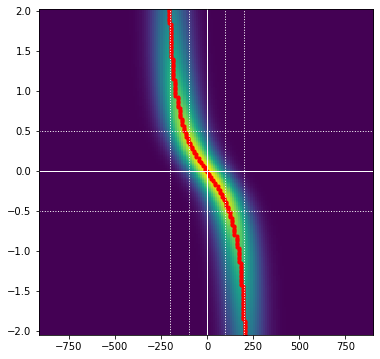

In [7]:
#%matplotlib
%matplotlib inline

ncol=1

fig,ax = plt.subplots(1,ncol,figsize=(6,6))
ax.imshow(data,extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto')

ax.plot(peak_info['peak_loc'],np.flip(grid_x),color='red', marker='o', markersize=3,ls='none')

vcen = 0.

ax.axhline(y=0.0    ,color='white' , linestyle='-',lw=1)
ax.axhline(y=0.5    ,color='white' , linestyle=':',lw=1)
ax.axhline(y=-0.5   ,color='white', linestyle=':' ,lw=1)
ax.axvline(x=vcen    ,color='white', linestyle='-',lw=1)
ax.axvline(x=vcen+100,color='white', linestyle=':',lw=1)
ax.axvline(x=vcen-100,color='white', linestyle=':',lw=1)
ax.axvline(x=vcen+200,color='white', linestyle=':',lw=1)
ax.axvline(x=vcen-200,color='white', linestyle=':',lw=1)
    
#ax.set_xlim(-220,220)
#ax.set_ylim(-1.5,1.5)

plt.show()

## 1D gaussian fit

In [8]:
row_id=0
flux     = data[row_id]

In [9]:
start_cen = peak_info['peak_loc'][row_id]
print(start_cen)
start_amp = peak_info['peak_flux'][row_id]
print(start_amp)

-205.50589616204525
1129.9287306282056


In [10]:
best_vals=_fit_Gauss1D_atX(data,pos_id=row_id,grid_v=grid_v)
best_vals

array([ 2.04536535e+05, -2.03274358e+02,  7.21810211e+01])

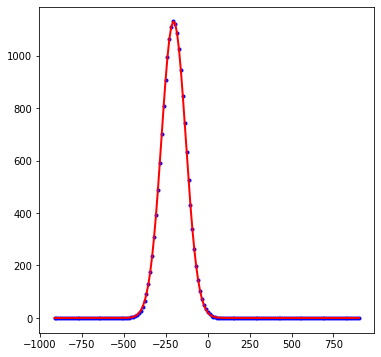

In [11]:
#%matplotlib
%matplotlib inline
fig,ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(grid_v,flux,color='blue', marker='o', markersize=3,ls='none')

ax.plot(grid_v,gaussian(grid_v,*best_vals),linewidth=2,color='r')

In [12]:
fitted_amp,fitted_peakV,fitted_sigma = fit_spec2D(data,grid_v)

time cost: 0.2877218723297119 (secs)


/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## gen_fit_spec2D

In [13]:
Ngrid_x,Ngrid_v=data.shape
model = gen_fit_spec2D(fitted_amp,fitted_peakV,fitted_sigma,Ngrid_x,Ngrid_v,grid_v)

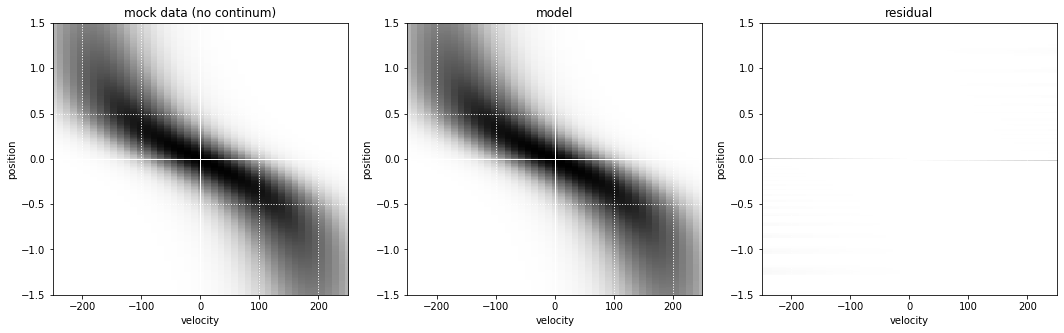

In [14]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(18,5))
#ax[0].imshow(np.sum(modelGrid,axis=2))
ax[0].imshow(data ,extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto',cmap='Greys',vmin=0)
ax[1].imshow(model,extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto',cmap='Greys',vmin=0)
ax[2].imshow((data-model)/data,extent=[v_min, v_MAX, x_min, x_MAX ], aspect='auto',cmap='Greys',vmin=0)

#ycen = (pars['lambda_min']+pars['lambda_max'])/2.
vcen = 0.

for j in range(ncol):
    ax[j].axhline(y=0.0,color='white', linestyle='-',lw=1)
    ax[j].axhline(y=0.5,color='white', linestyle=':',lw=1)
    ax[j].axhline(y=-0.5,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen,color='white', linestyle='-',lw=1)
    ax[j].axvline(x=vcen+100,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen-100,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen+200,color='white', linestyle=':',lw=1)
    ax[j].axvline(x=vcen-200,color='white', linestyle=':',lw=1)
    
    ax[j].set_xlim(-250,250)
    ax[j].set_ylim(-1.5,1.5)
    ax[j].set_xlabel('velocity')
    ax[j].set_ylabel('position')
    
ax[0].set_title('mock data (no continum)')
ax[1].set_title('model')
ax[2].set_title('residual')

plt.show()

In [15]:
grid_v

array([-9.13359538e+02, -9.01942544e+02, -8.90525550e+02, -8.79108556e+02,
       -8.67691562e+02, -8.56274567e+02, -8.44857573e+02, -8.33440579e+02,
       -8.22023585e+02, -8.10606590e+02, -7.99189596e+02, -7.87772602e+02,
       -7.76355608e+02, -7.64938613e+02, -7.53521619e+02, -7.42104625e+02,
       -7.30687631e+02, -7.19270637e+02, -7.07853642e+02, -6.96436648e+02,
       -6.85019654e+02, -6.73602660e+02, -6.62185665e+02, -6.50768671e+02,
       -6.39351677e+02, -6.27934683e+02, -6.16517688e+02, -6.05100694e+02,
       -5.93683700e+02, -5.82266706e+02, -5.70849712e+02, -5.59432717e+02,
       -5.48015723e+02, -5.36598729e+02, -5.25181735e+02, -5.13764740e+02,
       -5.02347746e+02, -4.90930752e+02, -4.79513758e+02, -4.68096763e+02,
       -4.56679769e+02, -4.45262775e+02, -4.33845781e+02, -4.22428787e+02,
       -4.11011792e+02, -3.99594798e+02, -3.88177804e+02, -3.76760810e+02,
       -3.65343815e+02, -3.53926821e+02, -3.42509827e+02, -3.31092833e+02,
       -3.19675838e+02, -